Rotation angles: [0.09434383 3.3843243  3.46832029 4.75822338 4.54257946 3.77502614]
Coupling map:


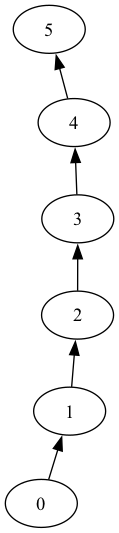

In [10]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np

num_qubits = 6
rotation_axes = ["rx", "ry", "rx", "ry", "rx", "ry"]
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, False)
print("Rotation angles:", rotation_angles)
print('Coupling map:')
cm.draw()

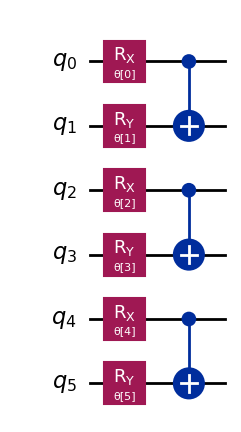

In [11]:
circuit = circuit_context(num_qubits, rotation_axes, rotation_parameters, coupling_map=cm)
circuit.draw("mpl")

In [35]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.025  # γ_0->1
gamma_matrix[0, 3] = 0.3  # γ_0->3
gamma_matrix[1, 2] = 0.25  # γ_1->2
gamma_matrix[2, 3] = 0.0  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.025  # γ_4->3
gamma_matrix[5, 4] = 0.025  # γ_5->4

# gamma_matrix = np.random.uniform(0, 1, (num_qubits, num_qubits))
print("Gamma matrix:")
print(gamma_matrix)

Gamma matrix:
[[0.    0.025 0.    0.3   0.    0.   ]
 [0.    0.    0.25  0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.025 0.    0.   ]
 [0.    0.    0.    0.    0.025 0.   ]]


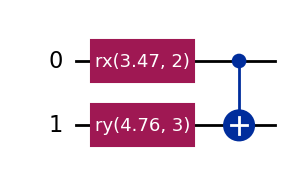

In [36]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [37]:
backend = noisy_backend(circuit.assign_parameters(param_dict), gamma_matrix, target_subsystem=(2, 3), coupling_map=cm)

In [38]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '1f8077da911641e6b883c73f7cec68a4',
   'operations': ['rx(3.47, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[ 0.91184491+0.j, -0.41053484+0.j],
              [ 0.41053484+0.j,  0.91184491+0.j]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]},
  {'type': 'qerror',
   'id': '93824a86449147b49cf1cbf086fd7fa9',
   'operations': ['ry(4.76, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99748525+0.j        , 0.        -0.07087435j],
              [0.        -0.07087435j, 0.99748525+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [39]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[ 0.11760765+0.j        ,  0.        +0.71349675j,
            0.11233704+0.j        ,  0.        +0.68152125j],
          [ 0.        -0.68152125j, -0.11233704+0.j        ,
            0.        +0.71349675j,  0.11760765+0.j        ],
          [-0.11233704+0.j        ,  0.        -0.68152125j,
            0.11760765+0.j        ,  0.        +0.71349675j],
          [ 0.        +0.71349675j,  0.11760765+0.j        ,
            0.        +0.68152125j,  0.11233704+0.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))


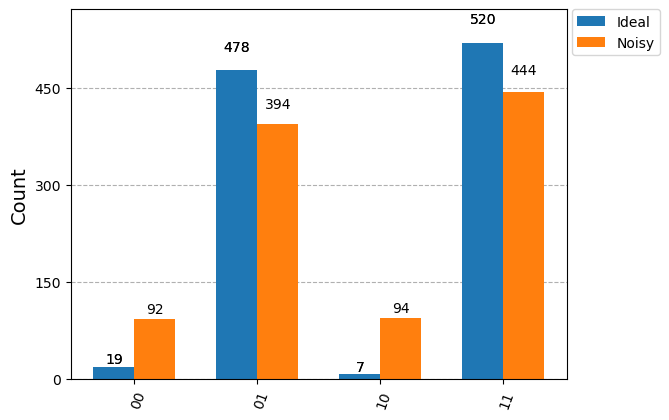

In [40]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [41]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
qc_noisy_ideal_state.save_statevector()
qc_noisy_state.save_statevector()

ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
noisy_state = backend.run(qc_noisy_state).result().get_statevector()

In [42]:
output_fidelity = state_fidelity(ideal_state, noisy_state)
output_fidelity

0.8488127063132646

In [43]:
ideal_state

Statevector([ 0.11760765+0.j        ,  0.        -0.68152125j,
             -0.11233704+0.j        ,  0.        +0.71349675j],
            dims=(2, 2))


In [44]:
noisy_state

Statevector([ 1.26800060e-01-0.28491873j,  1.08444304e-04-0.62330087j,
             -1.22936537e-01+0.27148406j,  4.11634605e-03+0.6522309j ],
            dims=(2, 2))
